## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 2. Load Data

In [2]:
# Custom normalization based on Fashion-MNIST statistics
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2913,), (0.3552,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Shapes:\n  Dataset:\n    Train - {train_dataset.data.shape}\n    Test - {test_dataset.data.shape}\n  Individual samples:\n    Train - {train_dataset[0][0].shape}\n    Test - {test_dataset[0][0].shape}')

Train samples: 60000
Test samples: 10000
Shapes:
  Dataset:
    Train - torch.Size([60000, 28, 28])
    Test - torch.Size([10000, 28, 28])
  Individual samples:
    Train - torch.Size([1, 28, 28])
    Test - torch.Size([1, 28, 28])


## 3. Exploratory Data Analysis

In [3]:
# For the Exploratory Data Analysis please check the EDA notebook.
# If you have any questions, please contact me at account.proton.me.boondocks460@passinbox.com
# Happy tinkering! :)

## 4. Define Model

In [4]:
class FashionNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(FashionNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = FashionNet().to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 109,386


## 5. Training Setup

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

## 6. Training Functions

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

## 7. Train Model

In [7]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | '
          f'Test Loss={test_loss:.4f}, Acc={test_acc:.2f}%')

print(f'\nFinal Test Accuracy: {test_accs[-1]:.2f}%')

Epoch 1/10: Train Loss=0.5567, Acc=79.85% | Test Loss=0.4324, Acc=84.00%
Epoch 2/10: Train Loss=0.4145, Acc=85.07% | Test Loss=0.3964, Acc=85.69%
Epoch 3/10: Train Loss=0.3760, Acc=86.31% | Test Loss=0.3702, Acc=86.39%
Epoch 4/10: Train Loss=0.3550, Acc=87.04% | Test Loss=0.3795, Acc=86.22%
Epoch 5/10: Train Loss=0.3400, Acc=87.53% | Test Loss=0.3590, Acc=86.80%
Epoch 6/10: Train Loss=0.3277, Acc=87.96% | Test Loss=0.3479, Acc=87.10%
Epoch 7/10: Train Loss=0.3154, Acc=88.41% | Test Loss=0.3476, Acc=87.45%
Epoch 8/10: Train Loss=0.3058, Acc=88.82% | Test Loss=0.3399, Acc=87.77%
Epoch 9/10: Train Loss=0.3005, Acc=89.04% | Test Loss=0.3450, Acc=87.65%
Epoch 10/10: Train Loss=0.2902, Acc=89.26% | Test Loss=0.3311, Acc=88.01%

Final Test Accuracy: 88.01%


## 8. Visualize Results

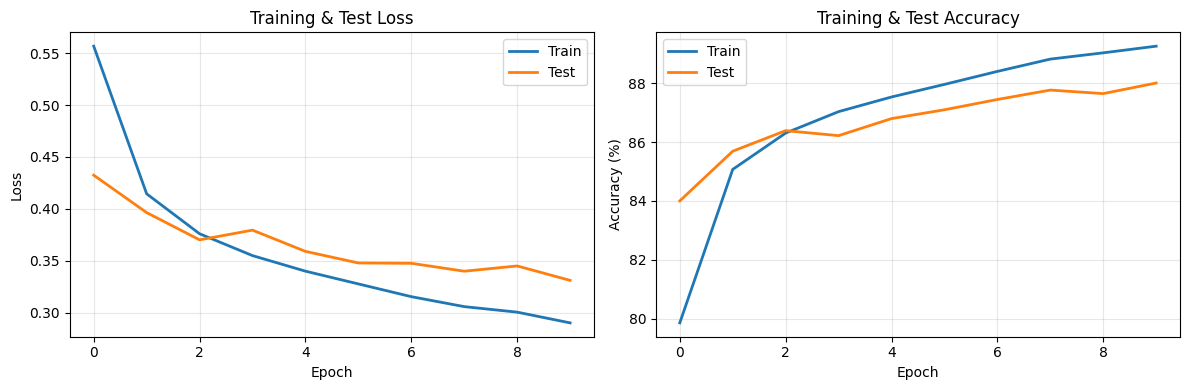

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train', linewidth=2)
ax1.plot(test_losses, label='Test', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Test Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(train_accs, label='Train', linewidth=2)
ax2.plot(test_accs, label='Test', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Test Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()